[<img src="../XRO_logo.png" width="500">](https://github.com/senclimate/XRO) 

Author: Sen Zhao <zhaos@hawaii.edu>

In this notebook, we will demonstrate how to fit, simulate and reforecast ENSO with the python `XRO` library.

1) XRO fitting on observation 
3) XRO stochastic simulation
4) XRO determintic reforecasting
5) XRO stochastic reforecasting

This examples may be executed within 5 minutes in a personal computer.

See our paper Zhao et al. 2024[[1]](#1) for details of analysis. If you encounter problems in running `XRO`, please feel free to contact Sen Zhao (zhaos@hawaii.edu).

<a id="1">[1]</a> 
Zhao, S., Jin, F.-F., Stuecker, M.F., Thompson, P.R., Kug, J.-S., McPhaden, M.J., Cane, M.A., Wittenberg, A.T., Cai, W.,. Explainable El Niño predictability from climate mode interactions. Nature. https://doi.org/10.1038/s41586-024-07534-6


## Libraries

Include libraries for both computing and visualization

In [1]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "climpred", "dateutil", "nc-time-axis",
]

# # Install missing packages
# for pkg in required_packages:
#     install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import datetime
from dateutil.relativedelta import *

import numpy as np
import xarray as xr

from climpred import HindcastEnsemble

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [2]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# !wget -c https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
# !wget -c https://github.com/senclimate/XRO/raw/main/code/XRO.py

## XRO models in different complexities

Here we include two versions of XRO model:

    - XRO model with annual mean, annual cycle, and semi-annual cycles components (XROac2)
    - XRO model with annual mean component only (XROac0)

Notes:
1. The monthly time series is used to train the XRO model, so we set `ncycle=12`. Therefore, the XRO simulate/reforecast output is also monthly mean time series.
2. It should be noted that the XRO accept higher resolution data such as (ncycle=52 for weekly data and ncycle=365 for daily data), similarly the output of simulate/reforecast will be weakly or daily automatically.


In [3]:
from XRO import XRO

# XRO model with annual mean, annual cycle, and semi-annual cycle
XROac2 = XRO(ncycle=12, ac_order=2)

# XRO model without annual cycles
XROac0 = XRO(ncycle=12, ac_order=0)

## XRO data prepration

Following Zhao et al. (2024), the standard XRO include the state vectors of ENSO and other climate modes in global oceans.
which includes $X_{ENSO}=[T_{ENSO}, WWV]$ and $X_M=[T_{NPMM},T_{SPMM},T_{IOB},T_{IOD},T_{SIOD},T_{TNA},T_{ATL3},T_{SASD}]$, respectively.

See the defitions of those SST and WWV indices from Zhao et al. (2024). For briefty, here we use the observed indices from ORAS5 reanalysis for 1979-2024 as an exmaple.



<xarray.Dataset> Size: 29kB
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...
    NPMM     (time) float32 2kB ...
    SPMM     (time) float32 2kB ...
    IOB      (time) float32 2kB ...
    IOD      (time) float32 2kB ...
    SIOD     (time) float32 2kB ...
    TNA      (time) float32 2kB ...
    ATL3     (time) float32 2kB ...
    SASD     (time) float32 2kB ...


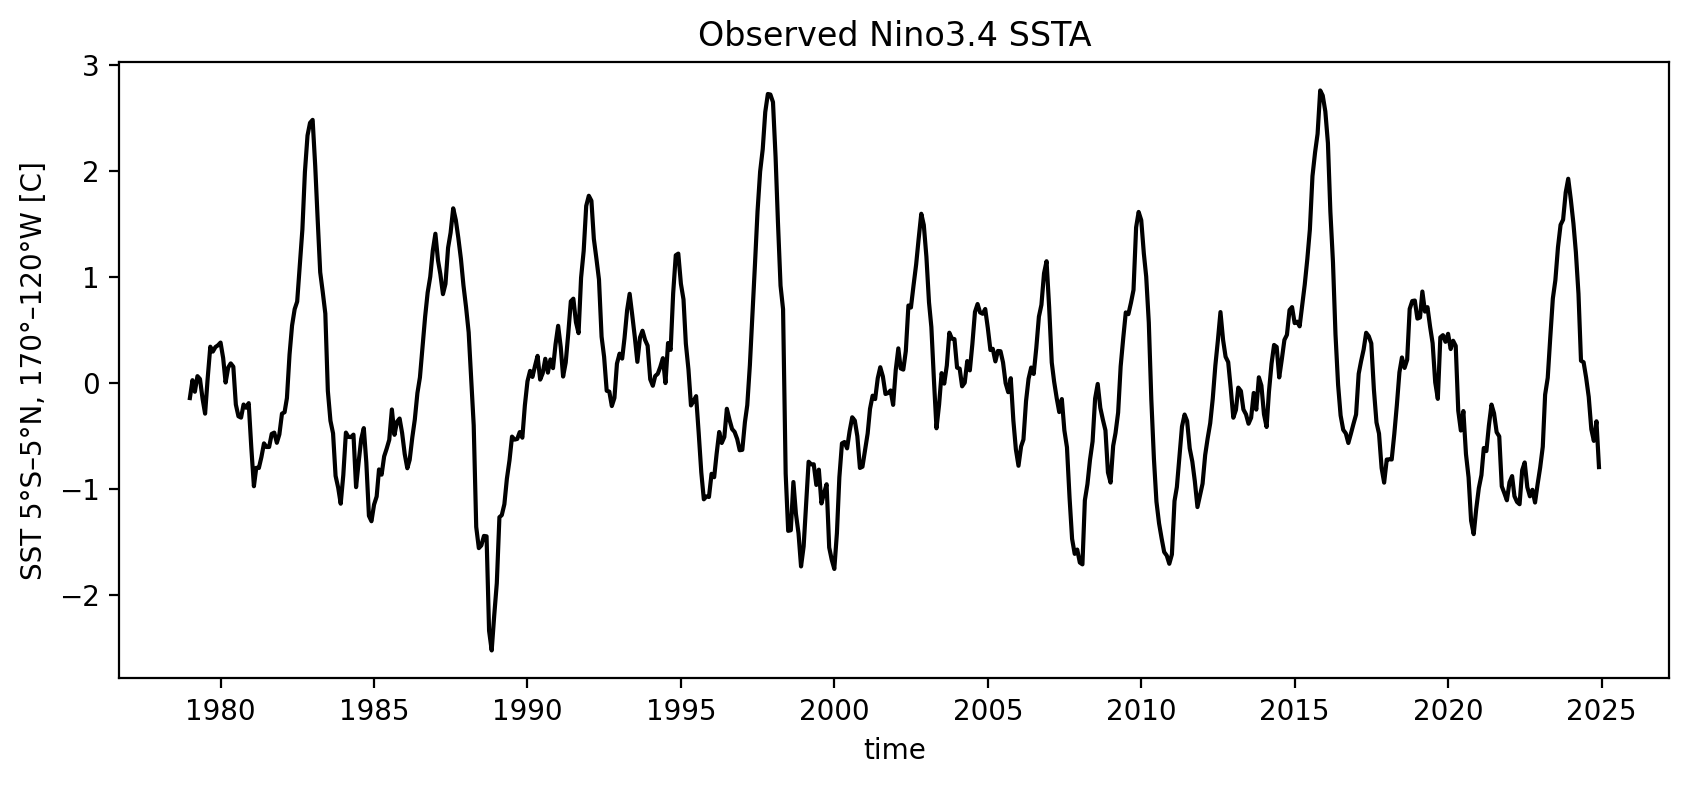

In [4]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_ds = xr.open_dataset('../data/XRO_indices_oras5.nc')
print(obs_ds)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
obs_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_title('Observed Nino3.4 SSTA')

# select 1979-01 to 2022-12 as training data
train_ds = obs_ds.sel(time=slice('1979-01', '2022-12'))

## XRO training

The XRO model form : dX/dt = L * X + NRO_T + NRO_H + maskb * Ib * X^2 + maskc * Ic * X^3

**XRO equation forms**

- The standard XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus `maskb=['IOD']`, `maskNT=['T2', 'TH']`
- The linear form of XRO is setting `maskb=[]` and `maskNT=[]`

In [5]:
# XRO model used as control experiment in the paper
XROac2_fit = XROac2.fit_matrix(train_ds, maskb=['IOD'], maskNT=['T2', 'TH'])
print('XRO control model parameters')
print(XROac2_fit)

# XRO ac=0 model
XROac0_fit = XROac0.fit_matrix(train_ds, maskb=['IOD'], maskNT=['T2', 'TH'])
print('XRO(ac=0) model parameters')
print(XROac0_fit)

XROac2Lin_fit = XROac2.fit_matrix(train_ds, maskb=[], maskNT=[])
print('XRO linear model parameters')
print(XROac2Lin_fit)

XRO control model parameters
<xarray.Dataset> Size: 182kB
Dimensions:         (ranky: 10, rankx: 10, cycle: 12, ac_rank: 3, cossin: 5,
                     time: 528, nro_form: 5)
Coordinates:
  * rankx           (rankx) int32 40B 1 2 3 4 5 6 7 8 9 10
  * cycle           (cycle) float64 96B 0.04167 0.125 0.2083 ... 0.875 0.9583
  * ac_rank         (ac_rank) int32 12B 0 1 2
  * cossin          (cossin) int32 20B 0 1 2 3 4
  * time            (time) float64 4kB 0.04167 0.125 0.2083 ... 43.88 43.96
  * ranky           (ranky) int32 40B 1 2 3 4 5 6 7 8 9 10
  * nro_form        (nro_form) <U3 60B 'T2' 'TH' 'T3' 'T2H' 'TH2'
Data variables: (12/31)
    Lac             (ranky, rankx, cycle) float64 10kB -2.226 -2.143 ... -1.959
    Lcomp           (ranky, rankx, cycle, ac_rank) float64 29kB -0.7937 ... 0...
    Lcoef           (ranky, rankx, cossin) float64 4kB -0.7937 ... -0.2527
    X               (rankx, time) float64 42kB -0.1423 0.02629 ... 0.2558 0.9523
    Y               (ranky, time)

## XRO stochastic simulation

stochastic simulation (as an example, initial from observed 1979-01, each model run 100 years with 100 realiazations)

- set `seed` to int number to get the exact same result (default is None)
- set `is_xi_stdac=True` if consider seasonal modulation of noise amplitde (default is True)

The output is archived as monthly mean of state vectors


In [6]:
seed = 2000
XROac2_sim = XROac2.simulate(fit_ds=XROac2_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, is_xi_stdac=False, seed=seed)  
print('XRO control stochastic simulation')
print(XROac2_sim)

XROac0_sim = XROac0.simulate(fit_ds=XROac0_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, is_xi_stdac=False, seed=seed)  #set seed=1000 to get the exact same result
print('XRO(ac=0) model stochastic simulation')
print(XROac0_sim)

XROac2Lin_sim = XROac0.simulate(fit_ds=XROac2Lin_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, is_xi_stdac=False, seed=seed)  #set seed=1000 to get the exact same result
print('XRO(ac=2) linear model stochastic simulation')
print(XROac2Lin_sim)


XRO control stochastic simulation
<xarray.Dataset> Size: 10MB
Dimensions:  (time: 1200, member: 100)
Coordinates:
  * time     (time) object 10kB 0001-01-01 00:00:00 ... 0100-12-01 00:00:00
  * member   (member) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    Nino34   (time, member) float64 960kB -0.1731 -0.01722 ... 0.7885 0.7548
    WWV      (time, member) float64 960kB 11.08 12.22 13.82 ... -8.921 4.62
    NPMM     (time, member) float64 960kB -0.4224 -0.1866 ... 0.3998 0.2974
    SPMM     (time, member) float64 960kB 0.4254 0.5699 ... -0.0007723 0.02879
    IOB      (time, member) float64 960kB 0.189 0.1393 0.1387 ... 0.2251 0.1159
    IOD      (time, member) float64 960kB 0.1502 0.3622 0.3141 ... 0.3348 0.3424
    SIOD     (time, member) float64 960kB 0.3717 0.2805 ... 0.02437 0.1945
    TNA      (time, member) float64 960kB 0.1597 0.3012 ... 0.08252 -0.1423
    ATL3     (time, member) float64 960kB -0.0768 -0.08038 ... 0.8467 0.07435
    SASD     (tim

### Simulating Metric Exmaple 1: ENSO irregular interannual oscillations in XRO
Show the time series of each member

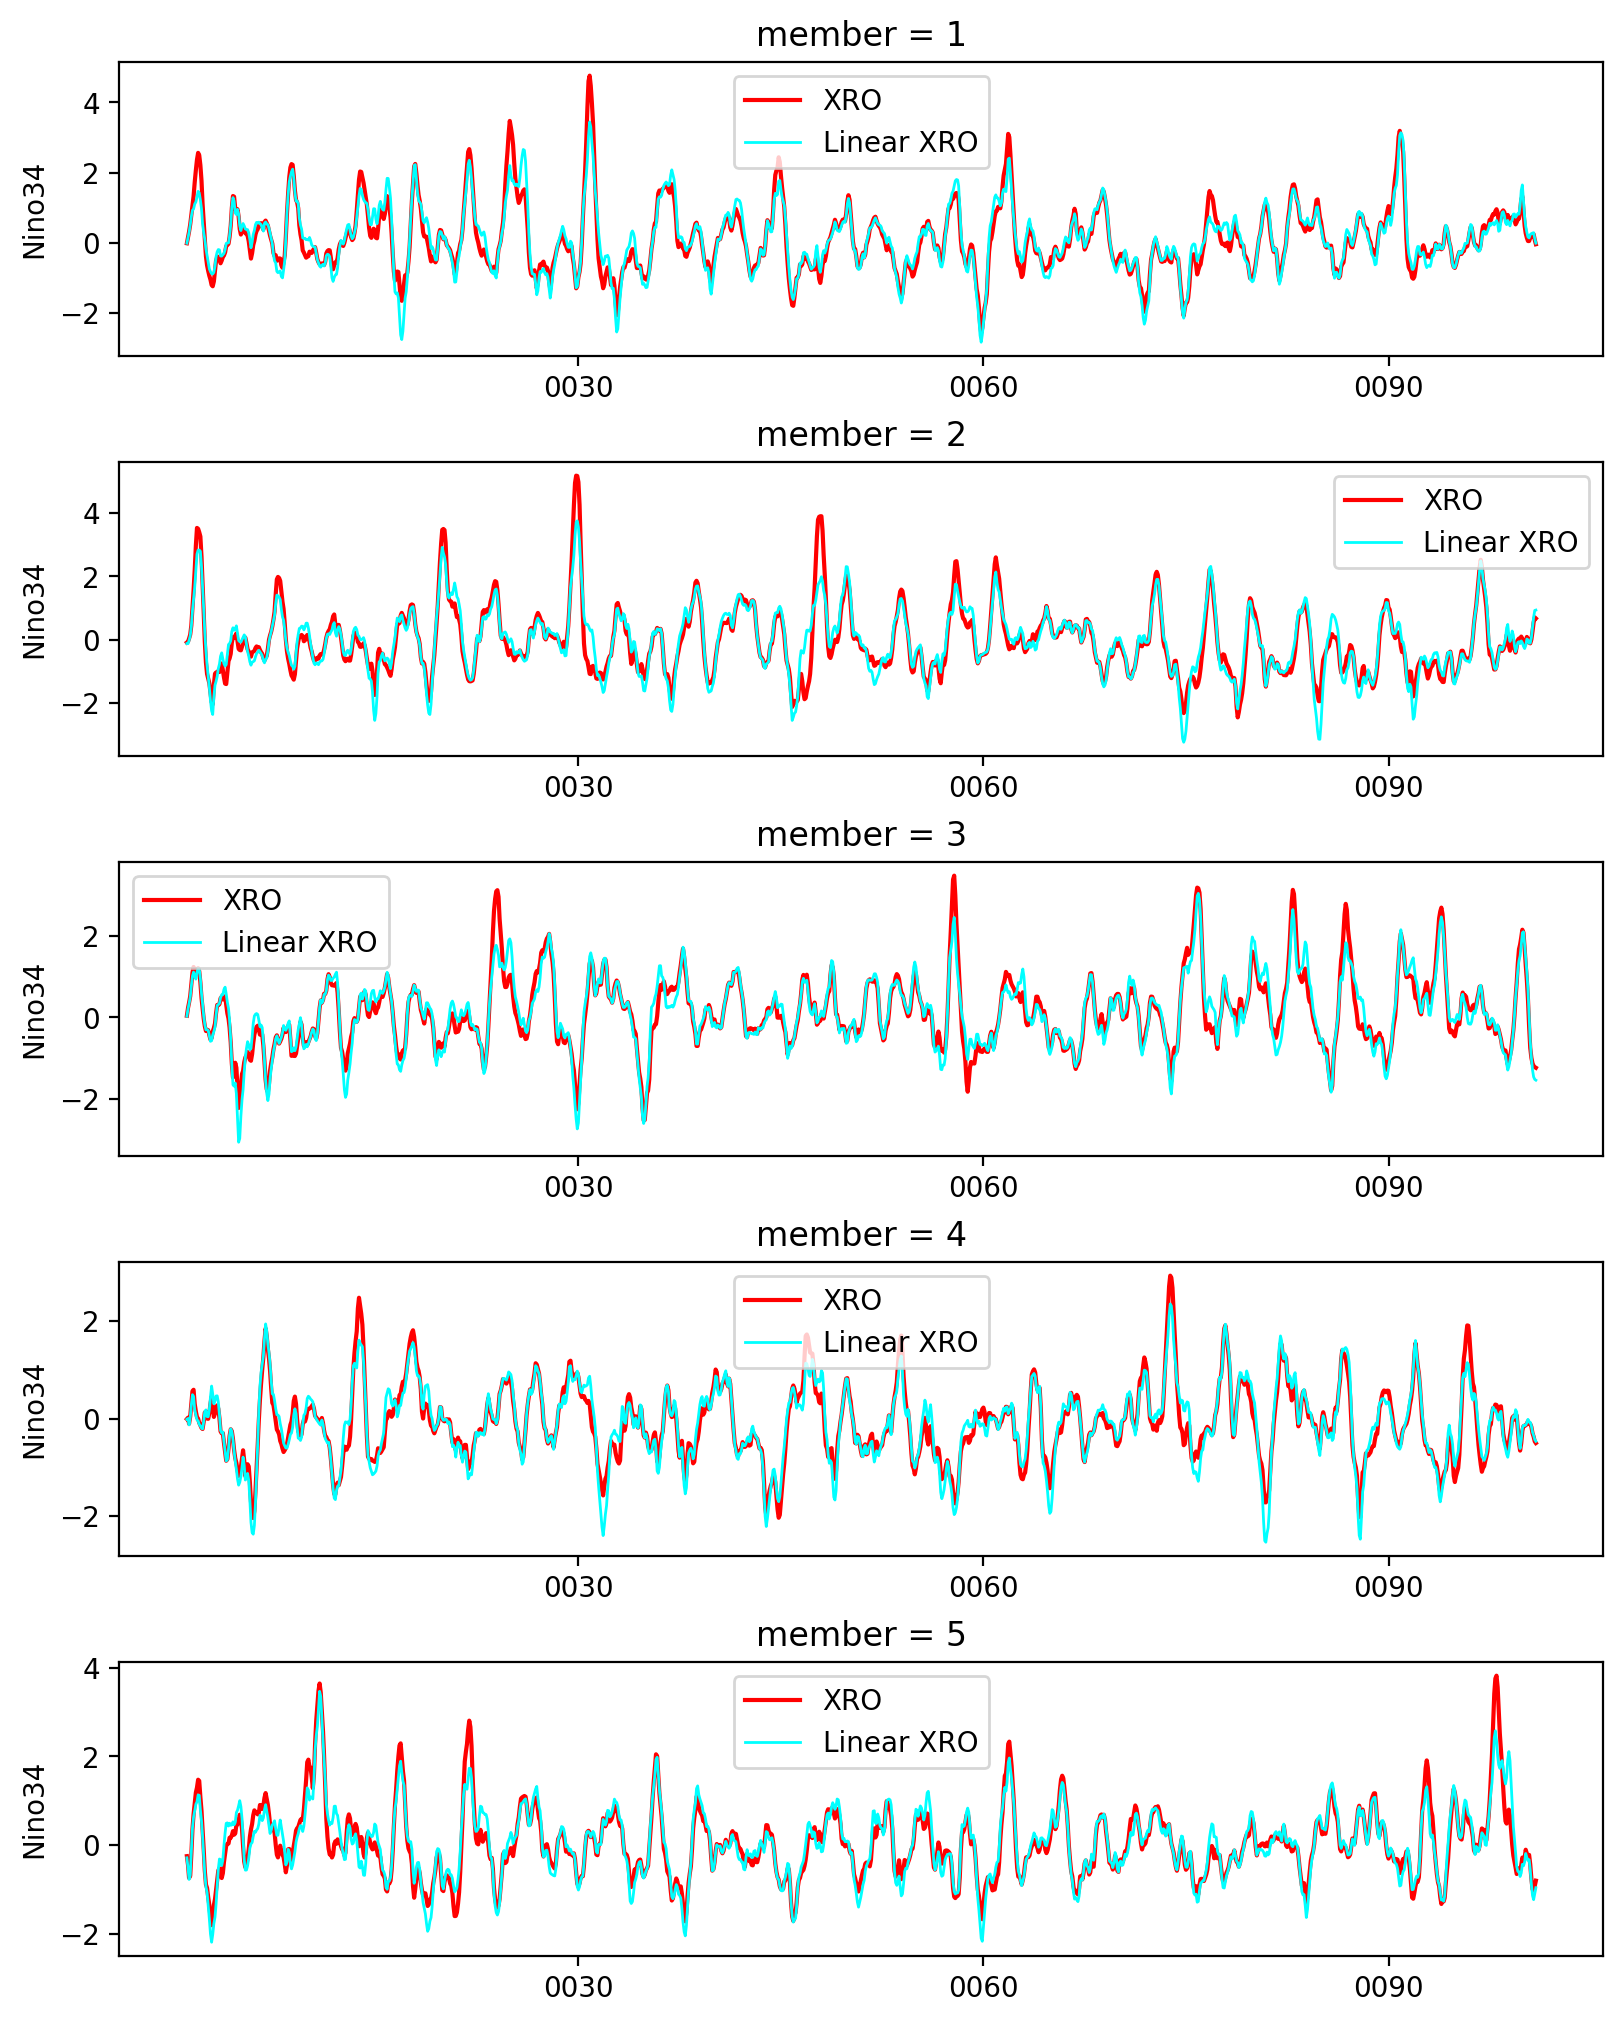

In [7]:
nmember=5
fig, axes = plt.subplots(nmember, 1, figsize=(8, nmember*2), layout='compressed')

for i, ax in enumerate(axes.flat):
    XROac2_sim.isel(member=i+1)['Nino34'].plot(ax=ax, c='r', lw=1.5, label='XRO')
    XROac2Lin_sim.isel(member=i+1)['Nino34'].plot(ax=ax, c='cyan', lw=1., label='Linear XRO')
    ax.set_xlabel('')
    ax.legend()

### Simulating Metric Exmaple 2: ENSO seasonal synchronization example

In the following code block, we calcualte the Nino34 seasonal standard deviation (stddev) for observation (ORAS5), XRO control simulation, and XRO(ac=0) simulation.

- As shown in the figure, XRO accurately simulates observed ENSO seasonal synchronization (comoare black curve and red curve)
- If we don't include the seasonal cycle in the XRO operators, there is no seasonal synchronization (blue curve)


Text(0.5, 1.0, 'XRO accurately simulates ENSO seasonal synchronization')

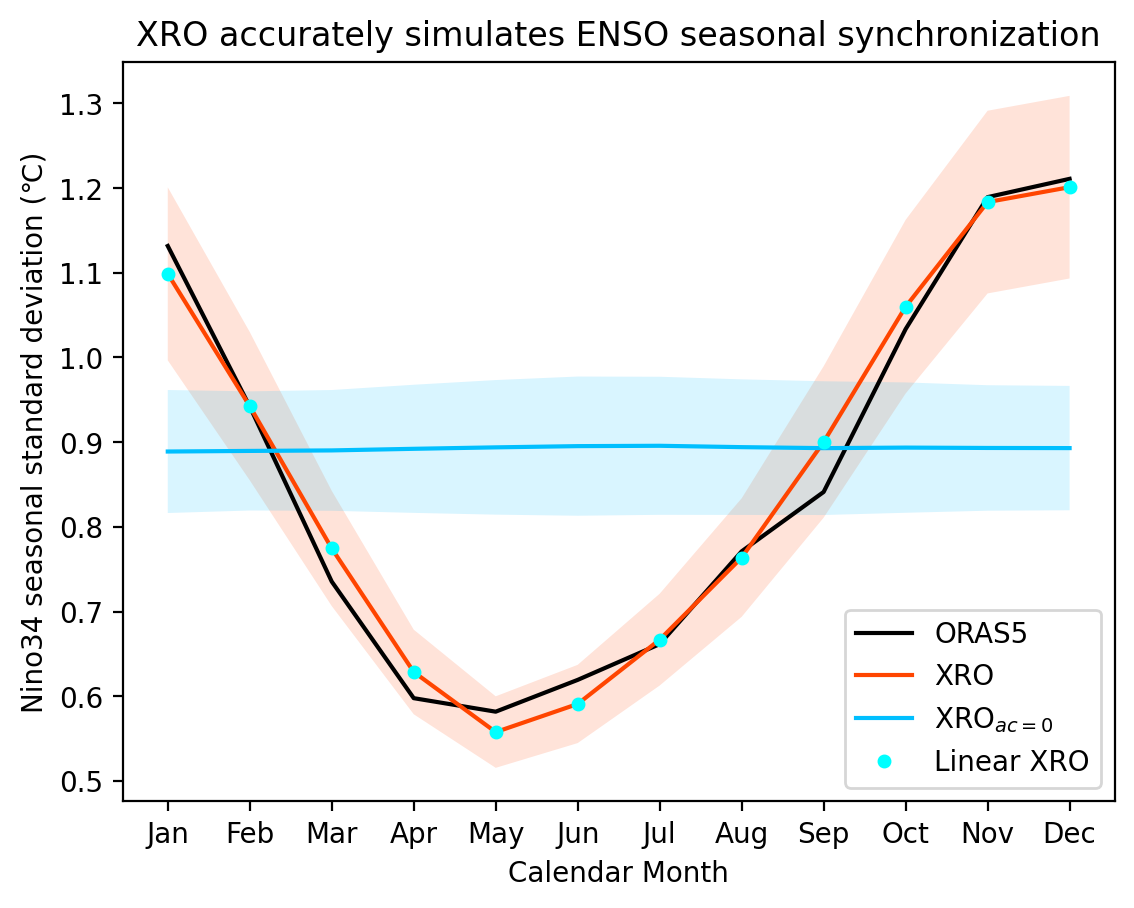

In [8]:
# as exmaple shown the 
stddev_obs = train_ds.groupby('time.month').std('time')

stddev_XROac2 = XROac2_sim.groupby('time.month').std('time')
stddev_XROac2_m = stddev_XROac2.mean('member')
stddev_XROac2_e = stddev_XROac2.std('member')

stddev_XROac0 = XROac0_sim.groupby('time.month').std('time')
stddev_XROac0_m = stddev_XROac0.mean('member')
stddev_XROac0_e = stddev_XROac0.std('member')

stddev_XROac2Lin = XROac2Lin_sim.groupby('time.month').std('time')
stddev_XROac2Lin_m = stddev_XROac2Lin.mean('member')
stddev_XROac2Lin_e = stddev_XROac2Lin.std('member')

sel_var = 'Nino34'
plt.plot(stddev_obs.month, stddev_obs[sel_var], c='black', label='ORAS5')
plt.plot(stddev_XROac2_m.month, stddev_XROac2_m[sel_var], c='orangered', label='XRO')
plt.fill_between(stddev_XROac2_m.month, (stddev_XROac2_m-stddev_XROac2_e)[sel_var], (stddev_XROac2_m+stddev_XROac2_e)[sel_var], fc='orangered', alpha=0.15)
plt.plot(stddev_XROac0_m.month, stddev_XROac0_m[sel_var], c='deepskyblue', label='XRO$_{ac=0}$')
plt.fill_between(stddev_XROac0_m.month, (stddev_XROac0_m-stddev_XROac0_e)[sel_var], (stddev_XROac0_m+stddev_XROac0_e)[sel_var], fc='deepskyblue', alpha=0.15)

plt.plot(stddev_XROac2_m.month, stddev_XROac2_m[sel_var], c='cyan', label='Linear XRO', marker='.', ls='None', ms=8)
# plt.fill_between(stddev_XROac2_m.month, (stddev_XROac2_m-stddev_XROac2_e)[sel_var], (stddev_XROac2_m+stddev_XROac2_e)[sel_var], fc='orange', alpha=0.1)

plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.title('XRO accurately simulates ENSO seasonal synchronization')


## XRO reforecasting

reforecasting (as an example, initial from observed 1979-01 to 2024-12, each run 21 months)
- `fit_ds` is the trained operators, in which linear/nonlinear operators `Lac`/`NLac` as well as noise parameters `xi_std` and `xi_a1` will be used
- `init_ds` is initial condictions, the order of variables has been the same with the trained parameters
- determinsitc forecast by setting `noise_type='zero'` 
- stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)


In [9]:
XROac0_fcst = XROac0.reforecast(fit_ds=XROac0_fit, init_ds=obs_ds, n_month=21, ncopy=1, noise_type='zero')
XROac0_fcst

XROac2_fcst = XROac2.reforecast(fit_ds=XROac2_fit, init_ds=obs_ds, n_month=21, ncopy=1, noise_type='zero')
print(XROac2_fcst)

XROac2Lin_fcst = XROac2.reforecast(fit_ds=XROac2Lin_fit, init_ds=obs_ds, n_month=21, ncopy=1, noise_type='zero')
# print(XROac2_fcst)

<xarray.Dataset> Size: 978kB
Dimensions:  (init: 552, lead: 22)
Coordinates:
  * init     (init) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * lead     (lead) int32 88B 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21
    month    (init) int32 2kB ...
Data variables:
    Nino34   (init, lead) float64 97kB -0.1423 -0.1175 ... 0.07097 0.1357
    WWV      (init, lead) float64 97kB 11.07 10.72 10.03 ... 4.736 4.443 4.28
    NPMM     (init, lead) float64 97kB -0.2535 -0.2735 ... -0.07105 -0.06788
    SPMM     (init, lead) float64 97kB 0.5069 0.4708 0.424 ... -0.07945 -0.08231
    IOB      (init, lead) float64 97kB 0.1875 0.145 0.08135 ... -0.07185 -0.0543
    IOD      (init, lead) float64 97kB 0.4317 0.34 0.1988 ... 0.03678 0.08091
    SIOD     (init, lead) float64 97kB 0.3119 0.2726 ... -0.001338 0.01938
    TNA      (init, lead) float64 97kB 0.2333 0.2822 ... -0.05936 -0.03513
    ATL3     (init, lead) float64 97kB -0.1872 -0.2102 ... -0.06422 -0.07742
    SASD     (init, 

### forecast skill performance using `climpred`


In [10]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

### correlation skill
In-sample correlation skill of XRO and XRO(ac=0) for 1979-2024

In [11]:
acc_XROac0 = calc_forecast_skill(XROac0_fcst, obs_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
# print(acc_XROac0)

acc_XROac2 = calc_forecast_skill(XROac2_fcst, obs_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
# print(acc_XROac2)

acc_XROac2Lin = calc_forecast_skill(XROac2Lin_fcst, obs_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
print(acc_XROac2Lin)


SHA256 hash of downloaded file: 28ab9464ec01db6e160ae0eebf67f702d48afc2d9a3becce7ce322d97ccdaf51
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 2kB
Dimensions:  (lead: 22)
Coordinates:
  * lead     (lead) int32 88B 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21
Data variables:
    Nino34   (lead) float64 176B 1.0 0.9876 0.9655 ... 0.4528 0.4121 0.3757
    WWV      (lead) float64 176B 1.0 0.9886 0.9706 ... 0.3972 0.3769 0.3631
    NPMM     (lead) float64 176B 1.0 0.9734 0.9188 ... 0.4995 0.4621 0.4263
    SPMM     (lead) float64 176B 1.0 0.9541 0.8568 ... 0.1551 0.151 0.1486
    IOB      (lead) float64 176B 1.0 0.9653 0.9066 ... 0.5241 0.5076 0.4904
    IOD      (lead) float64 176B 1.0 0.9334 0.811 0.6859 ... 0.1826 0.1708 0.147
    SIOD     (lead) float64 176B 1.0 0.9513 0.861 0.7736 ... 0.3125 0.254 0.2023
    TNA      (lead) float64 176B 1.0 0.9613 0.8787 ... 0.2639 0.2748 0.2808
    ATL3     (lead) float64 176B 1.0 0.9382 0.8131 ... 0.2674 0.2651 0.2639
    SASD     (lead) float64 176B 1.0 0.9481 0.8504 ... 0.2602 0.2578 0.2675
Attributes:
    prediction_skill_software:     climpred https://climpr

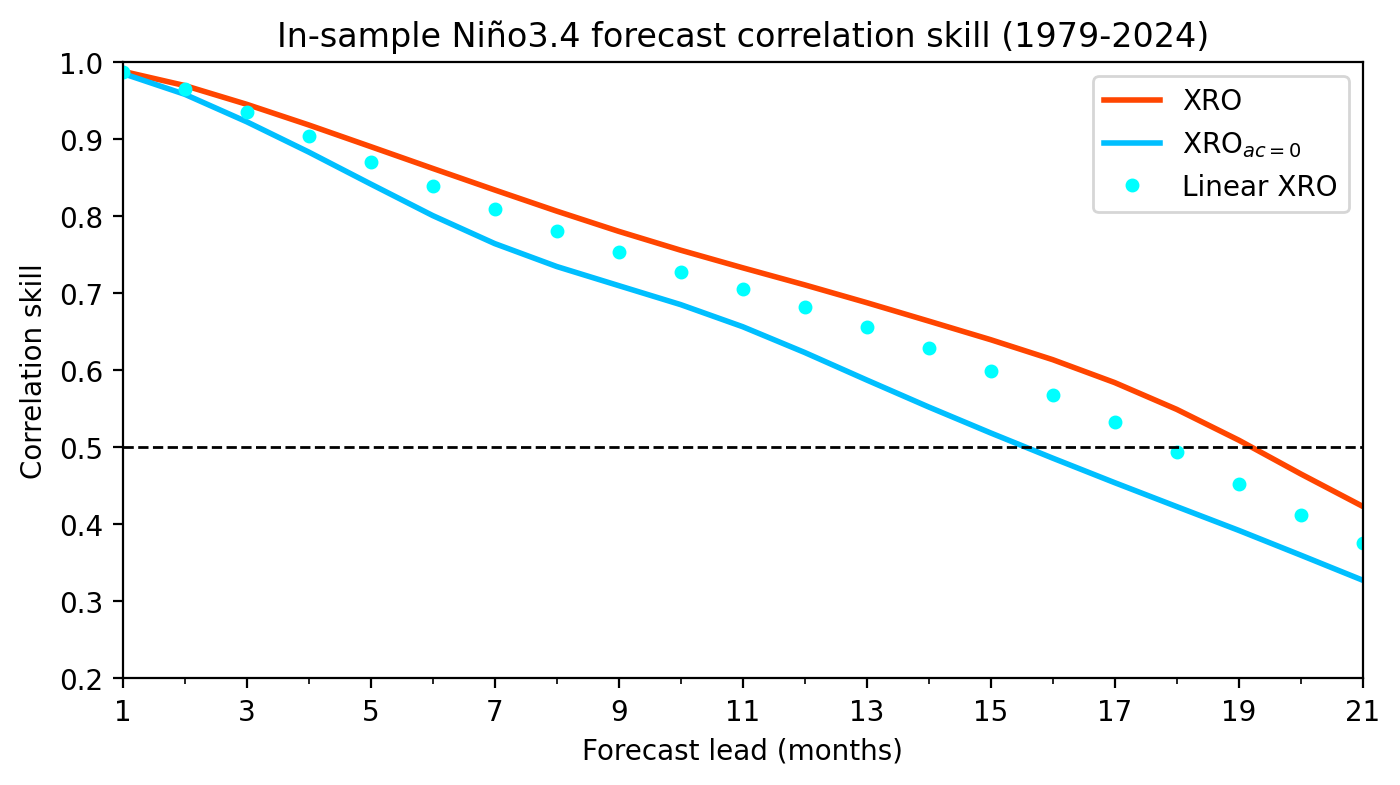

In [12]:
sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
acc_XROac2[sel_var].plot(ax=ax, label='XRO', c='orangered', lw=2)
acc_XROac0[sel_var].plot(ax=ax, label='XRO$_{ac=0}$', c='deepskyblue', lw=2)
acc_XROac2Lin[sel_var].plot(ax=ax, label='Linear XRO', c='cyan', ls='None', marker='.', ms=8)

ax.set_ylabel('{0} skill'.format('Correlation') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 21])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast correlation skill (1979-2024)')
ax.legend()

### RMSE skill

In-sample RMSE skill of XRO and XRO(ac=0) for 1979-2024

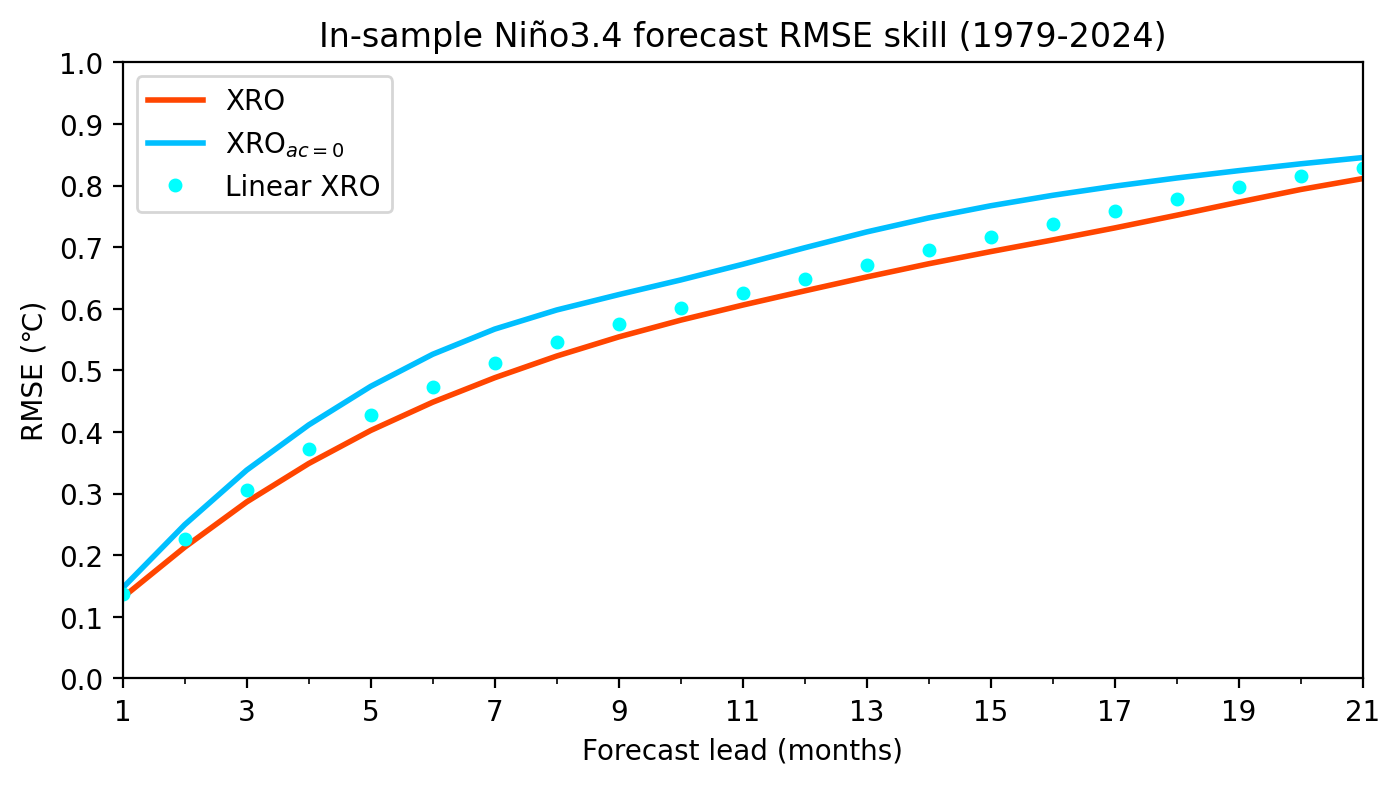

In [13]:
rmse_XROac0 = calc_forecast_skill(XROac0_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_XROac0

rmse_XROac2 = calc_forecast_skill(XROac2_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_XROac2

rmse_XROac2Lin = calc_forecast_skill(XROac2Lin_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_XROac2Lin


sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
rmse_XROac2[sel_var].plot(ax=ax, label='XRO', c='orangered', lw=2)
rmse_XROac0[sel_var].plot(ax=ax, label='XRO$_{ac=0}$', c='deepskyblue', lw=2)

rmse_XROac2Lin[sel_var].plot(ax=ax, label='Linear XRO', c='cyan', ls='None', marker='.', ms=8)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 21])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast RMSE skill (1979-2024)')
ax.legend()

## XRO stochastic reforecasting
 - stochastic forecast by setting `noise_type='red'` and `ncopy=50` (50 members)

It will take a while since you have 100 members, of course you can reduce the member size 

In [14]:
XROac2_fcst_stoc = XROac2.reforecast(fit_ds=XROac2_fit, init_ds=obs_ds, n_month=21, ncopy=100, noise_type='red')
print(XROac2_fcst_stoc)

XROac2Lin_fcst_stoc = XROac2.reforecast(fit_ds=XROac2Lin_fit, init_ds=obs_ds, n_month=21, ncopy=100, noise_type='red')
print(XROac2_fcst_stoc)

<xarray.Dataset> Size: 97MB
Dimensions:  (member: 100, init: 552, lead: 22)
Coordinates:
  * member   (member) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * init     (init) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * lead     (lead) int32 88B 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21
    month    (init) int32 2kB ...
Data variables:
    Nino34   (init, lead, member) float64 10MB -0.1423 -0.1423 ... 0.2448 0.2669
    WWV      (init, lead, member) float64 10MB 11.07 11.07 11.07 ... 3.064 5.337
    NPMM     (init, lead, member) float64 10MB -0.2535 -0.2535 ... -0.5689
    SPMM     (init, lead, member) float64 10MB 0.5069 0.5069 ... -0.000233
    IOB      (init, lead, member) float64 10MB 0.1875 0.1875 ... -0.1746 -0.1034
    IOD      (init, lead, member) float64 10MB 0.4317 0.4317 ... 0.1614 -0.1646
    SIOD     (init, lead, member) float64 10MB 0.3119 0.3119 ... -0.01703 0.1988
    TNA      (init, lead, member) float64 10MB 0.2333 0.2333 ... -0.050

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'Initialized from 1997-04'}, ylabel='Nino3.4 SST anomaly (℃)'>,
        <Axes: title={'center': 'Initialized from 1997-12'}, ylabel='Nino3.4 SST anomaly (℃)'>,
        <Axes: title={'center': 'Initialized from 2022-09'}, ylabel='Nino3.4 SST anomaly (℃)'>],
       dtype=object))

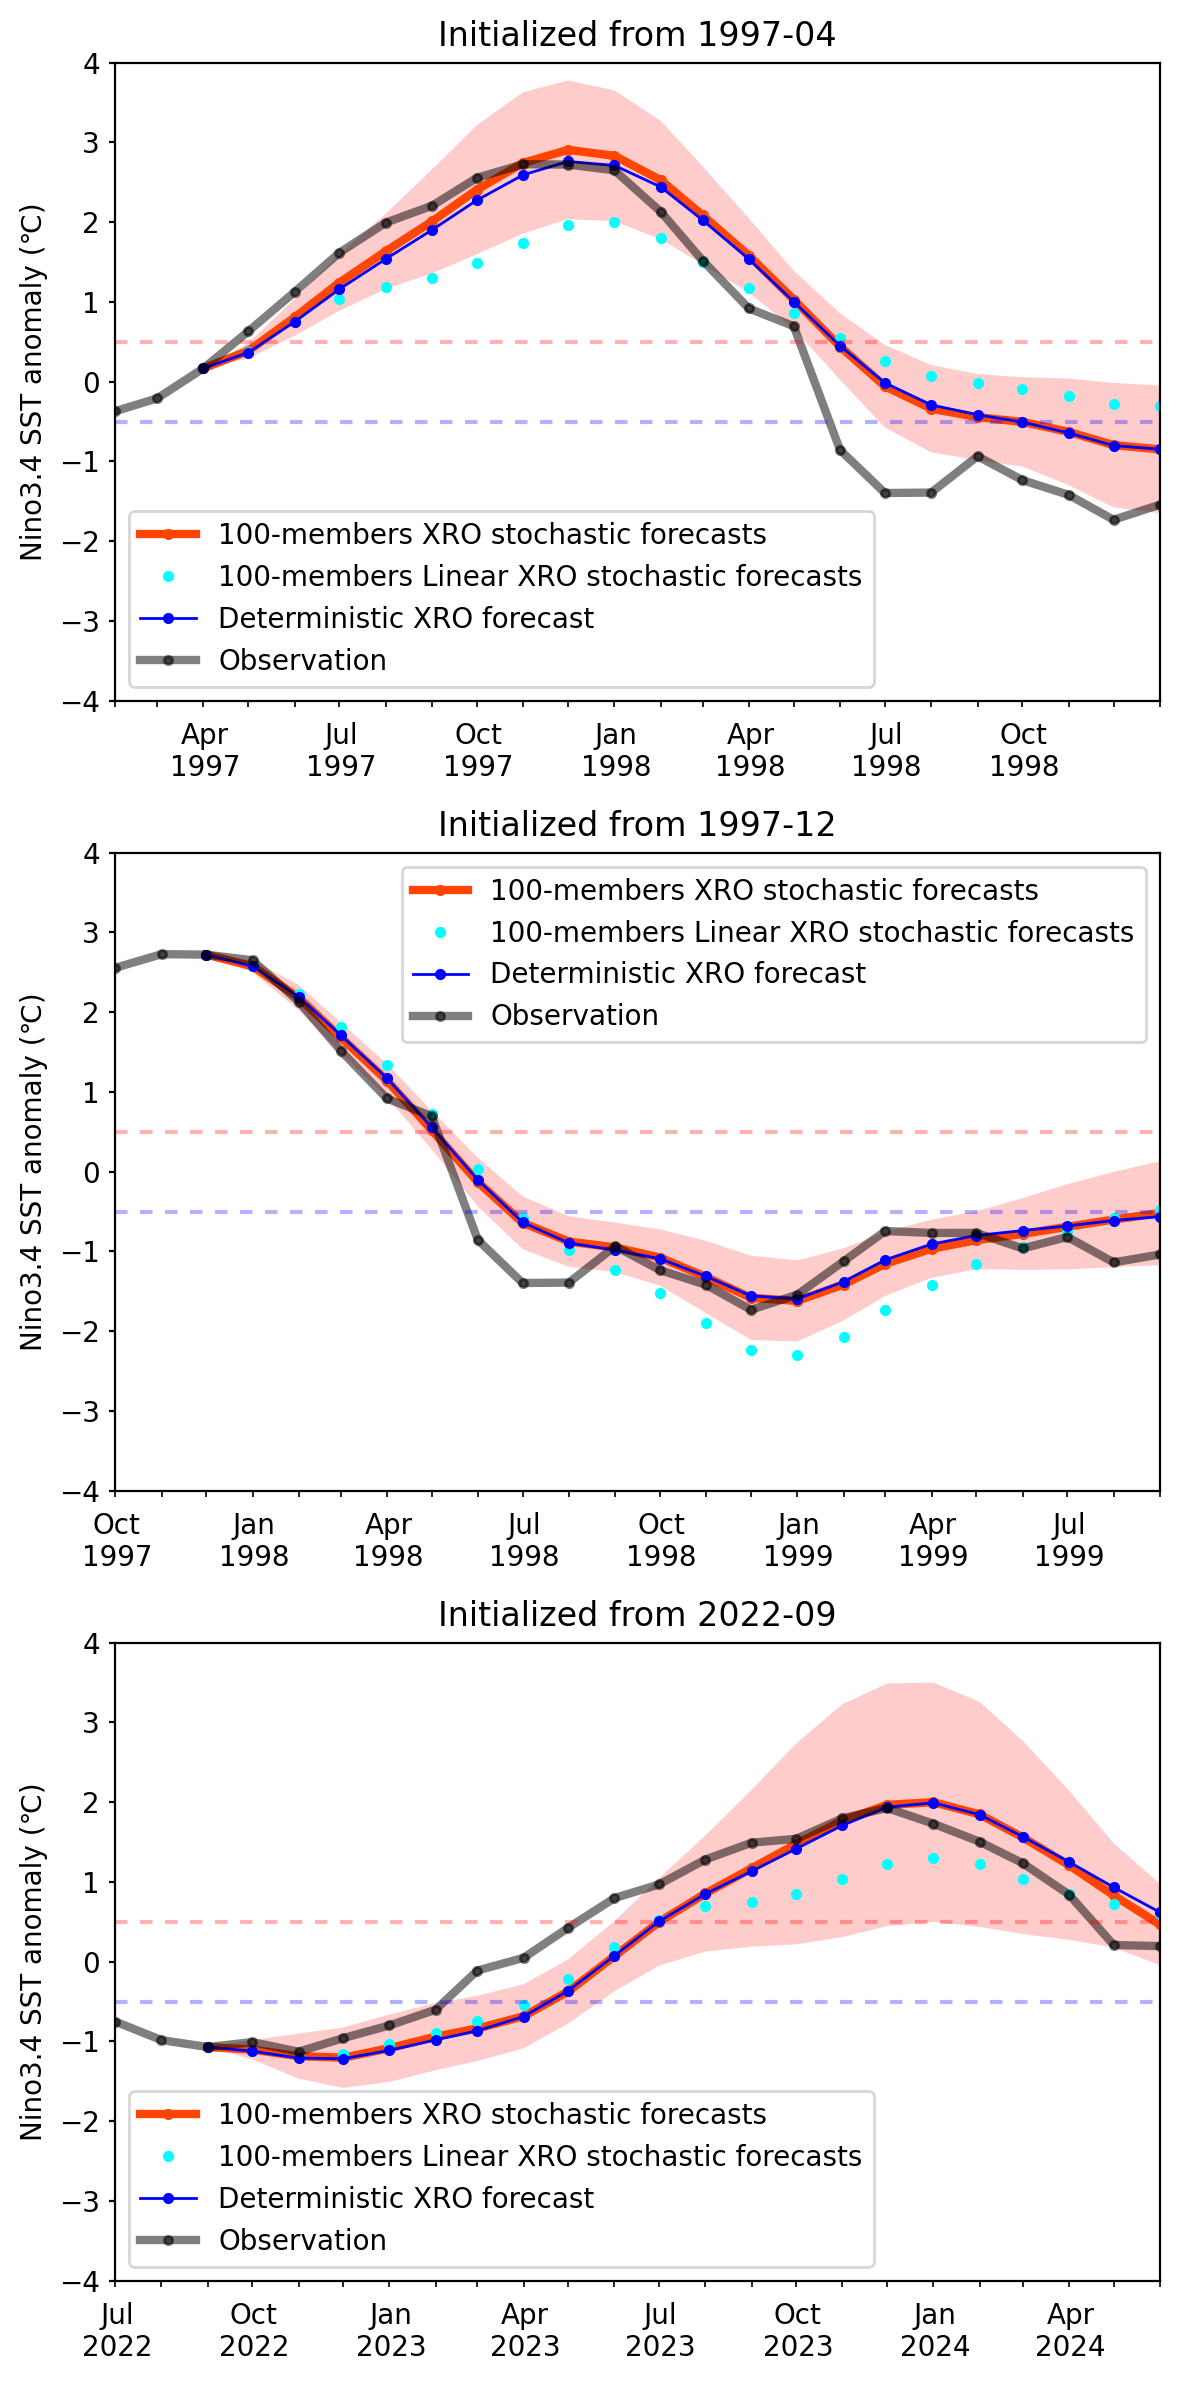

In [15]:

def plot_forecast_plume(date_arrs):
    n_arr = len(date_arrs)
    fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4 * n_arr), sharex=False, sharey=False)
    
    for i, sel_date in enumerate(date_arrs):
        ax = axes.flat[i] if n_arr > 1 else axes  # Handle single subplot case
    
        # Select deterministic and stochastic forecasts
        sel_fcst_d = XROac2_fcst['Nino34'].sel(init=sel_date).squeeze()
        
        sel_fcst_m = XROac2_fcst_stoc['Nino34'].sel(init=sel_date).mean('member').squeeze()
        sel_fcst_e = XROac2_fcst_stoc['Nino34'].sel(init=sel_date).std('member').squeeze()
    
        sel_Linfcst_m = XROac2Lin_fcst_stoc['Nino34'].sel(init=sel_date).mean('member').squeeze()
        sel_Linfcst_e = XROac2Lin_fcst_stoc['Nino34'].sel(init=sel_date).std('member').squeeze()
    
        nlead = len(sel_fcst_m.lead)  # Number of lead months
    
        # Corrected x-axis time handling
        xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
        xdate_strt = xdate_init + relativedelta(months= -2)
        xdate_last = xdate_init + relativedelta(months=nlead - 1)
    
        # Forecast time axis based on `lead` months
        xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]
    
        # Select observations in the matching time range
        sel_obs = obs_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
        xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility
    
        # Ensure forecast arrays are sliced correctly
        sel_fcst_m = sel_fcst_m.isel(lead=slice(0, nlead))
        sel_fcst_e = sel_fcst_e.isel(lead=slice(0, nlead))
        sel_Linfcst_m = sel_Linfcst_m.isel(lead=slice(0, nlead))
        sel_fcst_d = sel_fcst_d.isel(lead=slice(0, nlead))
    
        # Plot stochastic forecast with uncertainty
        ax.plot(xtime_fcst, sel_fcst_m, c='orangered', marker='.', lw=3, label='100-members XRO stochastic forecasts')
        ax.fill_between(xtime_fcst, sel_fcst_m - sel_fcst_e, sel_fcst_m + sel_fcst_e, fc='red', alpha=0.2)
    
        # Plot linear stochastic forecast
        ax.plot(xtime_fcst, sel_Linfcst_m, c='cyan', marker='.', ls='None', ms=6, label='100-members Linear XRO stochastic forecasts')
    
        # Plot deterministic forecast
        ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic XRO forecast')
    
        # Plot observations
        ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)
    
        # Formatting
        # ax.axhline(y=0., c='black', ls='-', lw=0.5)
        ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
        ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))
    
        ax.tick_params(axis="x", which="minor", length=2)
        ax.tick_params(axis="y", which="major", length=2)
        ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
        plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
        plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
        ax.set_xlim([xdate_strt, xdate_last])
    
        ax.set_title(f"Initialized from {sel_date}")
        ax.set_ylim([-4., 4.])
        ax.set_ylabel('Nino3.4 SST anomaly (℃)')
    
        ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
        ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)
    
        ax.legend()
    
    fig.tight_layout()
    return fig, axes

date_arrs = ['1997-04', '1997-12', '2022-09']
plot_forecast_plume(date_arrs)


(<Figure size 600x800 with 2 Axes>,
 array([<Axes: title={'center': 'Initialized from 2022-12'}, ylabel='Nino3.4 SST anomaly (℃)'>,
        <Axes: title={'center': 'Initialized from 2024-12'}, ylabel='Nino3.4 SST anomaly (℃)'>],
       dtype=object))

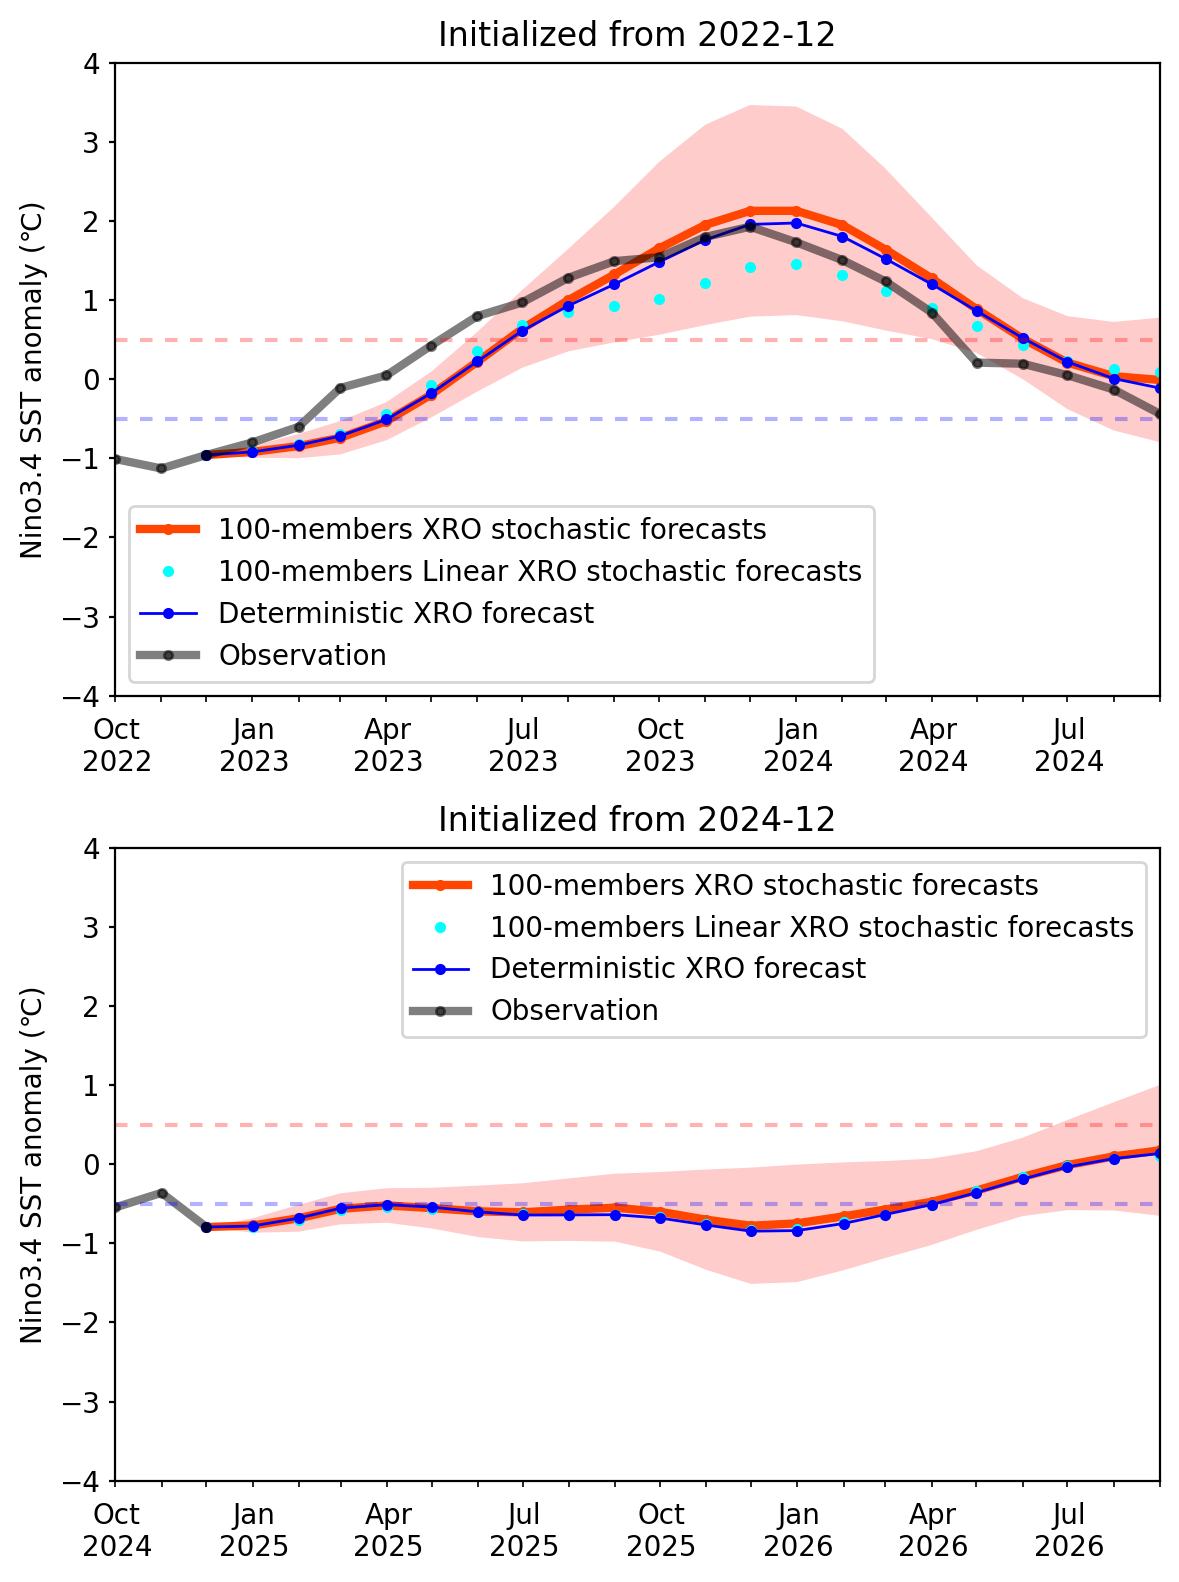

In [16]:
date_arrs = ['2022-12', '2024-12']
plot_forecast_plume(date_arrs)